# 1D Nozzle simulator

Author: Shaowu Pan


# Setup the area profile


In [1]:
import numpy as np
from matplotlib import pyplot as plt
# import scienceplots
import scipy
# plt.style.use(['science','ieee'])

class Nozzle(object):
    def __init__(self, Afunc, xmin, xmax, gamma, R) -> None:
        self.A = Afunc
        self.xmin = xmin 
        self.xmax = xmax 
        self.x = np.linspace(self.xmin,self.xmax,1000,endpoint=True)
        self.xeval = np.hstack([self.x,np.linspace(self.xmax, self.xmax + 1.5*(self.xmax-self.xmin),100)[1:]])
        # np.linspace(self.xmin,self.xmax + 0.1*(self.xmax - self.xmin),1100,endpoint=True)
        self.area_array = self.A(self.x)
        self.area_exit = self.A(self.xmax)
        self.x_throat = scipy.optimize.fmin(self.A, x0 = 0.5*(xmin+xmax),disp=False)[0]
        self.area_throat = self.A(self.x_throat)
        self.area_array_before_throat = self.area_array[self.x<=self.x_throat]
        self.area_array_after_throat = self.area_array[self.x>=self.x_throat]
        self.g = gamma
        self.R = R

        # compute critical pressures 1-2-3
        # Critical case pressure ratio(s) for Case 1 
        ratio = self.get_exit_area_over_throat()
        m_crit_1 = self.solve_mach_number_from_area_ratio(ratio=ratio, gamma=gamma, is_subsonic=True)
        p0_p = (1+(gamma-1)/2*m_crit_1**2)**(gamma/(gamma-1))
        self.crit_p_ratio_1 = 1/p0_p        

        # Critical case pressure ratio(s) for Case 2 - normal shock at the exit
        m_crit_2 = self.solve_mach_number_from_area_ratio(ratio=ratio, gamma=gamma, is_subsonic=False)
        p0_pe = (1+(gamma-1)/2*m_crit_2**2)**(gamma/(gamma-1))
        # normal shock
        p_ns_ratio = 1 + 2*gamma/(gamma+1)*(m_crit_2**2-1)
        self.crit_p_ratio_2 = p_ns_ratio/p0_pe

        # Critical case pressure ratio(s) for Case 3 - shockfree
        self.crit_p_ratio_3 = 1/p0_pe

        print(f"critical pressure rato (p_b/p_0) - chock =          {self.crit_p_ratio_1:.5f}")
        print(f"critical pressure rato (p_b/p_0) - normal shock =   {self.crit_p_ratio_2:.5f}")
        print(f"critical pressure rato (p_b/p_0) - shock free =     {self.crit_p_ratio_3:.5f}")

    # def plot_area_profile(self):
    #     plt.figure(figsize=(4,4))
    #     plt.plot(self.x,self.area_array)
    #     plt.xlabel('x',size=15)
    #     plt.ylabel('A(x)',size=15)
    #     plt.xlim([self.xmin, self.xmax])
    #     # plt.ylim([0, 0.6])
    #     plt.grid('on')
    #     plt.title('area profile of a Laval nozzle') 

    @classmethod
    def area_mach_relation(cls, m, gamma):
        """area mach number relation"""
        A_over_A_throat = np.sqrt((2/(gamma+1)*(1+(gamma-1)/2*m**2))**((gamma+1)/(gamma-1))/m**2)
        return A_over_A_throat
    
    @classmethod
    def prandtl_meyer(cls, M, gamma):
        """Prandtl–Meyer function ν(M) in radians, valid for M>=1."""
        M = np.asarray(M)
        nu = np.zeros_like(M, dtype=float)
    
        sup = M >= 1.0
        Ms = M[sup]
        if Ms.size > 0:
            a = np.sqrt((gamma + 1.0) / (gamma - 1.0))
            b = np.sqrt((gamma - 1.0) / (gamma + 1.0) * (Ms**2 - 1.0))
            nu[sup] = a * np.arctan(b) - np.arctan(np.sqrt(Ms**2 - 1.0))
        return nu if nu.shape else float(nu)

    # entropy rise across a normal shock as a function of M1
    @classmethod
    def entropy_jump_normal_shock(cls, M1, gamma, R):
        cp = gamma * R / (gamma - 1.0)
        pressure_ratio = 1 + (2 * gamma / (gamma + 1.0)) * (M1**2 - 1.0)
        temp_ratio = pressure_ratio * (2 + (gamma - 1.0) * M1**2) / ((gamma + 1.0) * M1**2)
        return cp * np.log(temp_ratio) - R * np.log(pressure_ratio)


    def plot_flow_profile(self, pb_p0_ratio):
        flag_draw_oshock = False 
        flag_draw_fan = False
        fan_alphas = None
        if pb_p0_ratio > self.crit_p_ratio_1:
            print(f"===\npb/p0 = {pb_p0_ratio:.3f} --> Subsonic Throat \n===")

            # first solve M_e using isentropic flow condition
            p0_pb = 1.0/pb_p0_ratio
            m_exit = np.sqrt((p0_pb**((self.g-1)/(self.g)) - 1)*2/(self.g-1))
            # infer A over A star via area mach relation
            Ae_over_A_star = self.area_mach_relation(m_exit, self.g)
            A_over_A_star = self.area_array / self.area_exit * Ae_over_A_star

            # solving M(x) from A over A star 
            M_array = np.zeros_like(self.xeval)
            p_array = np.zeros_like(self.xeval)
            
            for i in range(len(self.xeval)):
                if i < len(A_over_A_star):
                    ratio = A_over_A_star[i]
                    M_array[i] = self.solve_mach_number_from_area_ratio(ratio, self.g, is_subsonic=True)
                    p_array[i] = (1.0 + 0.5*(self.g - 1.0)*M_array[i]**2) ** (-self.g/(self.g - 1.0)) # 1.0/p0_pb**((self.g-1)/(self.g)) * (1 + (self.g-1)/2*M_array[i]**2)**(-self.g/(self.g-1))
                else:
                    M_array[i] = M_array[len(A_over_A_star)-1]
                    p_array[i] = p_array[len(A_over_A_star)-1]
            
        elif pb_p0_ratio > self.crit_p_ratio_2:
            # sonic throat but normal shock inside expansion
            print(f"===\npb/p0 = {pb_p0_ratio:.3f} --> Sonic Throat - Normal shock inside the expansion \n===")
            # p0_pb = 1.0/pb_p0_ratio
            
            # search for x_shock >= x_throat, but x_shock < x_max
            # we will try to define a function of x_shock, and try to match the pb_p0_ratio with the normal shock condition
            def M_and_p_given_x_shock(x_shock):
                last_index_before_shock = np.where(self.x < x_shock)[0][-1]
                M_array = np.zeros_like(self.xeval)
                p_array = np.zeros_like(self.xeval)
                A_over_A_star = self.area_array / self.area_throat 

                # for i, ratio in enumerate(A_over_A_star):
                for i in range(len(self.xeval)):
                    if i < len(self.x):
                        ratio = A_over_A_star[i]
                        
                        if self.x[i] < self.x_throat:
                            M_array[i] = self.solve_mach_number_from_area_ratio(ratio, self.g, is_subsonic=True)
                            p_array[i] = 1/(1+(self.g-1)/2*M_array[i]**2)**((self.g)/(self.g-1))
                        elif self.x[i] < x_shock:
                            M_array[i] = self.solve_mach_number_from_area_ratio(ratio, self.g, is_subsonic=False)
                            p_array[i] = 1/(1+(self.g-1)/2*M_array[i]**2)**((self.g)/(self.g-1))    
                        else:
                            # get preshock Mach number
                            M1 = M_array[last_index_before_shock]
                            # after the shock 
                            # first calculate total pressure loss
                            delta_s = self.entropy_jump_normal_shock(M1, self.g, R=self.R)
                            p0_new_p0 = np.exp(-delta_s/self.R)
                            # p0_new_p_exit = p0_new_p0 * p0_pb
                            M2 = np.sqrt((1+(self.g-1)/2*M1**2)/(self.g*M1**2-(self.g-1)/2))
    
                            # A / A_shock
                            A_over_A_shock = ratio*self.area_throat / self.get_area(self.x[last_index_before_shock+1])
    
                            # A_shock / A_star
                            A_shock_over_A_star = self.area_mach_relation(M2, self.g)
    
                            # A / A_star
                            A_over_A_star_tmp = A_over_A_shock * A_shock_over_A_star
    
                            # inverse modeling to find M 
                            M_array[i] = self.solve_mach_number_from_area_ratio(A_over_A_star_tmp, self.g, is_subsonic=True)
                            p_array[i] = p0_new_p0 * (1 + (self.g-1)/2*M_array[i]**2)**(-self.g/(self.g-1))
                    else:
                        M_array[i] = M_array[len(self.x)-1]
                        p_array[i] = p_array[len(self.x)-1]
                return M_array, p_array

            # find x_shock 
            mismatch_predicted_exit_pressure = lambda x_shock: M_and_p_given_x_shock(x_shock)[1][len(self.x)-1] - pb_p0_ratio
            x_shock = scipy.optimize.root_scalar(mismatch_predicted_exit_pressure, 
                                                 bracket=[self.x_throat, self.xmax], 
                                                 method='brentq', maxiter=1000,xtol=1e-7,rtol=1e-7).root
            M_array, p_array = M_and_p_given_x_shock(x_shock)

        elif pb_p0_ratio > self.crit_p_ratio_3:
            # critical case 3 is shockfree. so current pb is still higher, we are not there yet
            print(f"===\npb/p0 = {pb_p0_ratio:.3f} --> Sonic Throat - Oblique shock at the exit \n===")
            # sonic throat
            # oblique shock at the exit 
            flag_draw_oshock = True
            
            M_array = np.zeros_like(self.xeval)
            p_array = np.zeros_like(self.xeval)
            A_over_A_star = self.area_array / self.area_throat 

            r_exit = np.sqrt(self.area_array/np.pi)[-1]
            
            for i in range(len(self.xeval)):
                if i < len(self.x):
                    ratio = A_over_A_star[i]
                    if self.x[i] < self.x_throat:
                        M_array[i] = self.solve_mach_number_from_area_ratio(ratio, self.g, is_subsonic=True)
                        p_array[i] = 1/(1+(self.g-1)/2*M_array[i]**2)**((self.g)/(self.g-1))
                    else:
                        M_array[i] = self.solve_mach_number_from_area_ratio(ratio, self.g, is_subsonic=False)
                        p_array[i] = 1/(1+(self.g-1)/2*M_array[i]**2)**((self.g)/(self.g-1))
                elif i==len(self.x):
                    # at the exit, compute a oblique shock, we need to find M_{n,1}
                    M_exit = M_array[len(self.x)-1]
                    p_exit = p_array[len(self.x)-1]
                    pb_pe = pb_p0_ratio/p_exit
                    Mn1 = np.sqrt((pb_pe - 1)*(self.g+1)/(self.g*2) + 1)
                    Mn2 = np.sqrt((1+(self.g-1)/2*Mn1**2)/(self.g*Mn1**2-(self.g-1)/2))
                    beta = np.arcsin(Mn1/M_exit)
                    # solve delta/theta deflection angle
                    tan_theta = 2/np.tan(beta)*(M_exit**2*np.sin(beta)**2 - 1)/(M_exit**2*(self.g + np.cos(2*beta))+2)
                    theta = np.arctan(tan_theta)
                    # print(f"theta = {theta}")
                    # print(Mn1/M_exit) # Mn1 is larger than M_exit
                    # print(f"beta = {beta*180/np.pi} deg")
                    x_extended = self.xmax + r_exit/np.tan(beta)
                    M_array[i] = M_exit
                    p_array[i] = p_exit   
                elif self.xeval[i] >= x_extended:
                    M_array[i] = Mn2/np.sin(beta-theta)
                    p_array[i] = pb_p0_ratio
                else:
                    M_array[i] = M_array[len(self.x)-1]
                    p_array[i] = p_array[len(self.x)-1]   
        else:
            # expansion wave (underexpanded jet)
            print(f"===\npb/p0 = {pb_p0_ratio:.3f} --> Sonic Throat - Expansion fan at the exit \n===")
        
            g = self.g
            M_array = np.zeros_like(self.xeval)
            p_array = np.zeros_like(self.xeval)
            A_over_A_star = self.area_array / self.area_throat
        
            def p_over_p0(M):
                return (1.0 + 0.5*(g - 1.0)*M**2) ** (-g/(g - 1.0))
        
            # --- nozzle interior (isentropic, choked) ---
            for i in range(len(self.x)):
                ratio = A_over_A_star[i]
                if self.x[i] < self.x_throat:
                    M = self.solve_mach_number_from_area_ratio(ratio, g, is_subsonic=True)
                else:
                    M = self.solve_mach_number_from_area_ratio(ratio, g, is_subsonic=False)
        
                M_array[i] = M
                p_array[i] = p_over_p0(M)
        
            # --- exit state ---
            i_exit = len(self.x) - 1
            M_exit = M_array[i_exit]
            p_exit = p_array[i_exit]  # pe/p0
        
            # --- far-field Mach matching pb/p0 (isentropic inversion) ---
            M_far = np.sqrt((2.0/(g - 1.0)) * (pb_p0_ratio ** (-(g - 1.0)/g) - 1.0))
        
            # --- centerline hit region based on fan head/tail reaching centerline ---
            x_exit = self.xmax
            r_exit = np.sqrt(self.area_exit / np.pi)
        
            mu_exit = np.arcsin(np.clip(1.0 / M_exit, 0.0, 1.0))  # head (at exit state)
            mu_far  = np.arcsin(np.clip(1.0 / M_far,  0.0, 1.0))  # tail (fully expanded)
        
            # centerline first affected when head hits:
            x_head = x_exit + r_exit / np.tan(mu_exit)
            # centerline fully expanded when tail hits:
            x_tail = x_exit + r_exit / np.tan(mu_far)
        
            # your plotting window might not reach x_tail (esp. tiny pb/p0)
            x_end = self.xeval[-1]
            x_tail_eff = min(x_tail, x_end)
        
            def is_hit_by_fan_centerline(xq):
                return (xq >= x_head) and (xq <= x_tail_eff)
        
            # --- fill extended region using fan theory on centerline ---
            for i in range(len(self.x), len(self.xeval)):
                xq = self.xeval[i]
        
                if xq < x_head:
                    # not hit yet
                    M = M_exit
                    p = p_exit
        
                elif is_hit_by_fan_centerline(xq):
                    # hit region: use Mach-line geometry -> Mach angle -> Mach number
                    dx = max(xq - x_exit, 1e-12)
                    mu = np.arctan(r_exit / dx)            # ray angle from lip to centerline point
                    mu = np.clip(mu, mu_far, mu_exit)      # confine to fan [tail, head]
                    M  = 1.0 / np.sin(mu)                  # M from Mach angle
        
                    # (optional) also clamp to [M_exit, M_far] for numerical safety
                    M = float(np.clip(M, M_exit, M_far))
        
                    p = p_over_p0(M)
        
                else:
                    # past tail (only possible if x_tail is inside xeval)
                    if x_tail <= x_end:
                        M = M_far
                        p = pb_p0_ratio
                    else:
                        # window ends before tail hits; keep last value
                        M = M_array[i - 1]
                        p = p_array[i - 1]
        
                M_array[i] = M
                p_array[i] = p
        
            # only enforce pb exactly if the window actually reaches the tail
            if x_tail <= x_end:
                M_array[-1] = M_far
                p_array[-1] = pb_p0_ratio
            # --- for visualization (fan rays) ---
            flag_draw_fan = True
            fan_alphas = np.linspace(mu_far, mu_exit, 7)  # tail -> head

        # start to draw
        plt.figure(figsize=(12, 6))

        # Plot M(x) and p/p0(x) on primary axis
        plt.plot(self.xeval, M_array, color='green', linewidth=2, label='$M(x)$')  # Nature Blue
        plt.plot(self.xeval, p_array, color='orange', linestyle='--', linewidth=2, label=r'$p/p_0(x)$') # Nature Teal
        
        plt.xlabel('Axial Position $x$', fontsize=12)
        plt.ylabel('Mach Number / Pressure Ratio', fontsize=12)
        plt.xlim([min(self.xeval), max(self.xeval)])
        plt.ylim([0, 5])
        plt.grid(True, alpha=0.3)
        
        # Create secondary axis for area
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        
        # Plot area on secondary axis with Nature Red
        ax2.plot(self.x, np.sqrt(self.area_array/np.pi), color='black', linewidth=2, label='$A(x)$')  # Nature Red
        if flag_draw_oshock:
            r = 2*np.linspace(0, self.xmax - self.xmin, 5)
            ray_x = r*np.cos(-beta)
            ray_y = r*np.sin(-beta)
            x_arr = self.x[-1] + ray_x
            y_arr = np.sqrt(self.area_array/np.pi)[-1] + ray_y
            x_arr_2 = 0.01*(self.xmax - self.xmin)+self.x[-1] + ray_x
            y_arr_2 = 0.01*(max(np.sqrt(self.area_array/np.pi))-min(np.sqrt(self.area_array/np.pi))) + np.sqrt(self.area_array/np.pi)[-1] + ray_y
            ax2.plot(x_arr, y_arr, color='red', lw=2,label=f'shockwave\nbeta={beta*180/np.pi:.3f} degree')
            ax2.plot(x_arr_2, y_arr_2, color='red', lw=2)
            
        if flag_draw_fan and (fan_alphas is not None):
            x0 = self.x[-1]          # exit x
            r_exit = np.sqrt(self.area_array/np.pi)[-1]
            y0 = r_exit              # exit radius
            x_end = max(self.xeval)  # draw up to end of your extended domain
        
            for j, a in enumerate(fan_alphas):
                # line from (x0,y0) with downward slope toward centerline
                y_at_end = y0 - (x_end - x0) * np.tan(a)
        
                if y_at_end <= 0.0:
                    # it hits the centerline before x_end
                    x_hit = x0 + y0 / np.tan(a)
                    xs = np.array([x0, x_hit])
                    ys = np.array([y0, 0.0])
                else:
                    # it doesn't reach centerline within plotting window
                    xs = np.array([x0, x_end])
                    ys = np.array([y0, y_at_end])
        
                ax2.plot(xs, ys, linestyle="--", linewidth=1.5, color="blue",
                         label="expansion fan" if j == 0 else None)
        
        ax2.set_ylabel('Radius', fontsize=12, color='black')
        ax2.set_ylim([0,max(np.sqrt(self.area_array/np.pi))*1.1])
        ax2.tick_params(axis='y', labelcolor='black')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2,
                   loc='upper center',
                   bbox_to_anchor=(0.5, -0.15),  # Below the plot
                   ncol=4,
                   fontsize=10,
                   frameon=False)
        plt.tight_layout(rect=[0, 0.1, 1, 1])
        
        pass 

    def get_area(self, x):
        return self.A(x)

    def get_area_over_throat_at_x(self, x):
        return self.A(x)/self.area_throat

    def get_exit_area_over_throat(self):
        return self.area_exit/self.area_throat

    def get_area_over_throat(self, A):
        return A/self.area_throat

    def solve_mach_number_from_area_ratio(self, ratio, gamma, is_subsonic=True):
        eq = lambda m: m**2*ratio**2 - (2/(gamma+1)*(1+(gamma-1)/2*m**2))**((gamma+1)/(gamma-1)) 
        if is_subsonic:
            sol = scipy.optimize.root_scalar(eq, bracket=[0, 1], method='brentq', maxiter=1000,xtol=1e-7,rtol=1e-7)
        else:
            sol = scipy.optimize.root_scalar(eq, bracket=[1, 20], method='brentq', maxiter=1000,xtol=1e-7,rtol=1e-7)
        return sol.root

    @property
    def area_exit(self):
        return self._area_exit

    @area_exit.setter
    def area_exit(self,value):
        self._area_exit = value

    @property
    def area_throat(self):
        return self._area_throat
        
    @area_throat.setter
    def area_throat(self,value):
        self._area_throat = value

In [2]:
from rocketisp.geometry import Geometry
import numpy as np

# SSME Geometry from https://rocketisp.readthedocs.io/en/latest/models.html#geometry
G = Geometry(Rthrt=5.1527, CR=3.0, eps=77.5, LnozInp=121,
             RupThroat=1.0, RdwnThroat=0.392, RchmConv=1.73921, cham_conv_deg=25.42,
             LchmOvrDt=2.4842/2)

def get_A(G):
    noz = G.getNozObj()
    zL = [-G.Lcham] + noz.abs_zContour
    rL = [G.Dinj/2.0] + noz.abs_rContour
    # zL = list(reversed(zL)) + zL
    # rL = list(reversed(rL)) + [-r for r in rL]
    
    # Use numpy's interp function for linear interpolation
    # Note: zL must be sorted for numpy.interp
    z_array = np.array(zL)
    r_array = np.abs(rL)  # Take absolute value for radius
    
    # Ensure arrays are sorted by z (they should already be, but just in case)
    sort_idx = np.argsort(z_array)
    z_sorted = z_array[sort_idx]
    r_sorted = r_array[sort_idx]
    
    # Create area function using numpy.interp
    A = lambda x: np.pi * (np.interp(x, z_sorted, r_sorted))**2
    
    xmin = zL[0]
    xmax = zL[-1]
    return A, xmin, xmax

In [3]:
# demo 1: geometry of the nozzle  # ae/at aprrox 2
# A = lambda x: 1.5*(x-0.6)**2+0.25
# xmin = 0
# xmax = 1

# demo 2: Example usage:
A,xmin,xmax = get_A(G)

# Setup the inlet and outlet boundary conditions


In [4]:
g, R, T_0, p_0 = 1.4, 287, 273, 101325
R = 287

## 1: entirely subsonic 

critical pressure rato (p_b/p_0) - chock =          0.99996
critical pressure rato (p_b/p_0) - normal shock =   0.01837
critical pressure rato (p_b/p_0) - shock free =     0.00037
===
pb/p0 = 0.940 --> Sonic Throat - Normal shock inside the expansion 
===


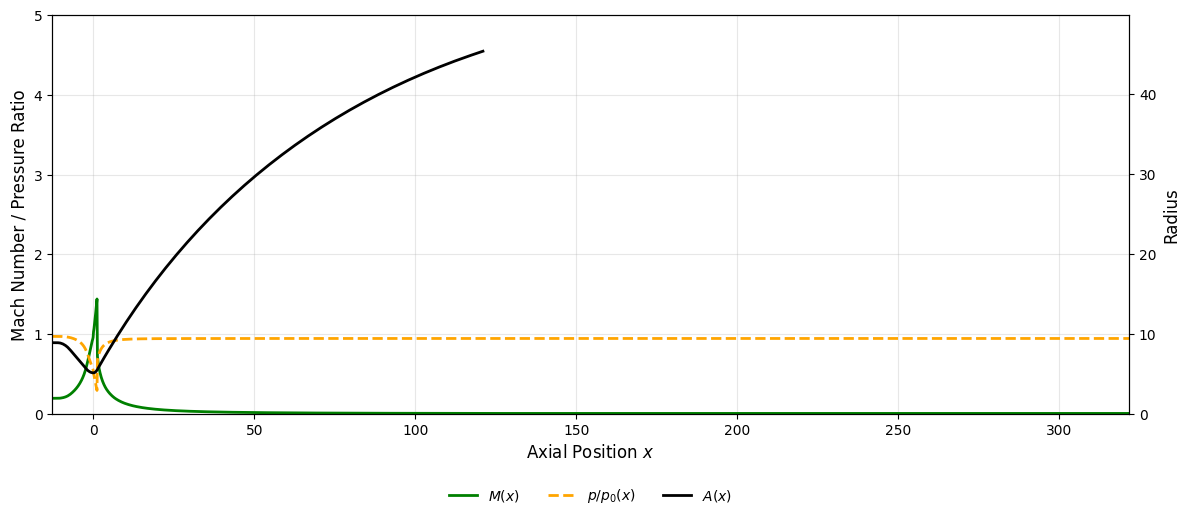

In [5]:
p_ratio = 0.94
p_b = p_ratio*p_0
nozzle = Nozzle(A, xmin=xmin, xmax=xmax, gamma=g, R=R)
nozzle.plot_flow_profile(p_ratio)

## 2: normal shock inside the expansion

critical pressure rato (p_b/p_0) - chock =          0.99996
critical pressure rato (p_b/p_0) - normal shock =   0.01837
critical pressure rato (p_b/p_0) - shock free =     0.00037
===
pb/p0 = 0.050 --> Sonic Throat - Normal shock inside the expansion 
===


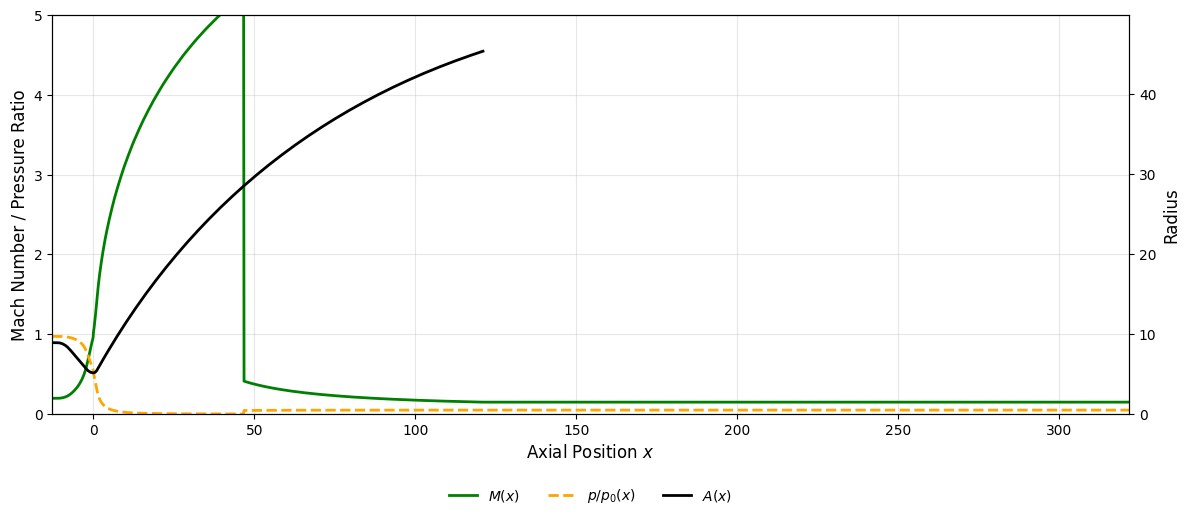

In [6]:
p_ratio = 0.05
p_b = p_ratio*p_0
nozzle = Nozzle(A, xmin=xmin, xmax=xmax, gamma=g,R=R)
nozzle.plot_flow_profile(p_ratio)

## 3. oblique shock in the exit

critical pressure rato (p_b/p_0) - chock =          0.99996
critical pressure rato (p_b/p_0) - normal shock =   0.01837
critical pressure rato (p_b/p_0) - shock free =     0.00037
===
pb/p0 = 0.015 --> Sonic Throat - Oblique shock at the exit 
===


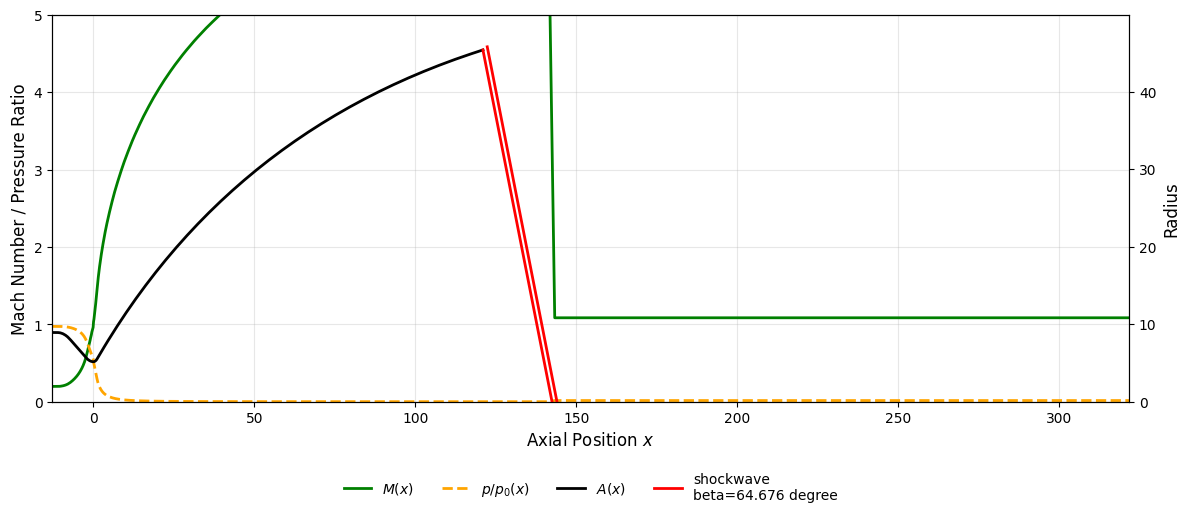

In [7]:
p_ratio = 0.015
p_b = p_ratio*p_0
nozzle = Nozzle(A, xmin=xmin, xmax=xmax, gamma=g,R=R)
nozzle.plot_flow_profile(p_ratio)

critical pressure rato (p_b/p_0) - chock =          0.99996
critical pressure rato (p_b/p_0) - normal shock =   0.01837
critical pressure rato (p_b/p_0) - shock free =     0.00037
===
pb/p0 = 0.000 --> Sonic Throat - Oblique shock at the exit 
===


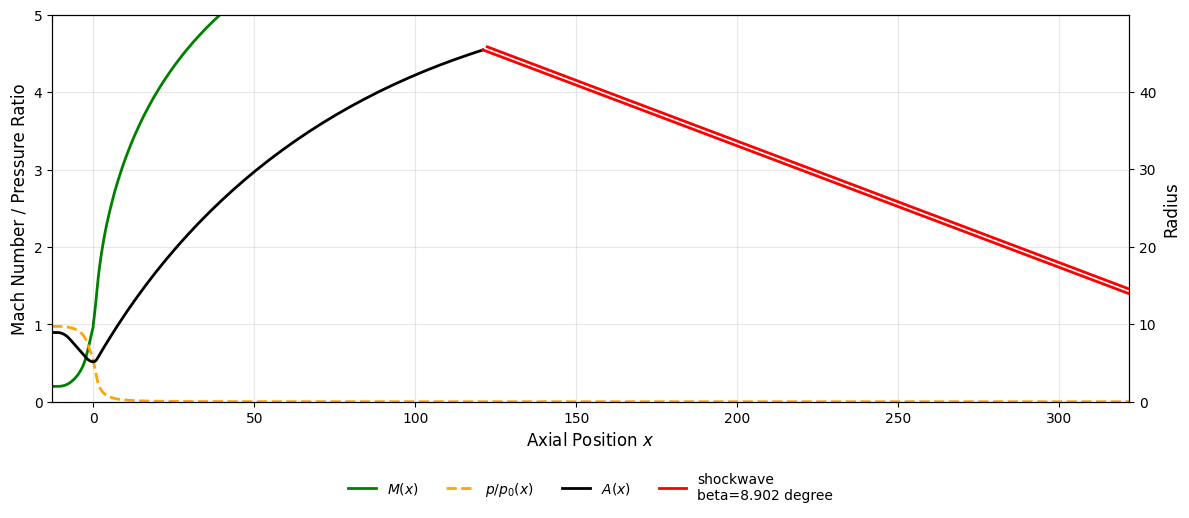

In [8]:
p_ratio = 0.00038
p_b = p_ratio*p_0
nozzle = Nozzle(A, xmin=xmin, xmax=xmax, gamma=g,R=R)
nozzle.plot_flow_profile(p_ratio)

# 4. expansion wave 

critical pressure rato (p_b/p_0) - chock =          0.99996
critical pressure rato (p_b/p_0) - normal shock =   0.01837
critical pressure rato (p_b/p_0) - shock free =     0.00037
===
pb/p0 = 0.000 --> Sonic Throat - Expansion fan at the exit 
===


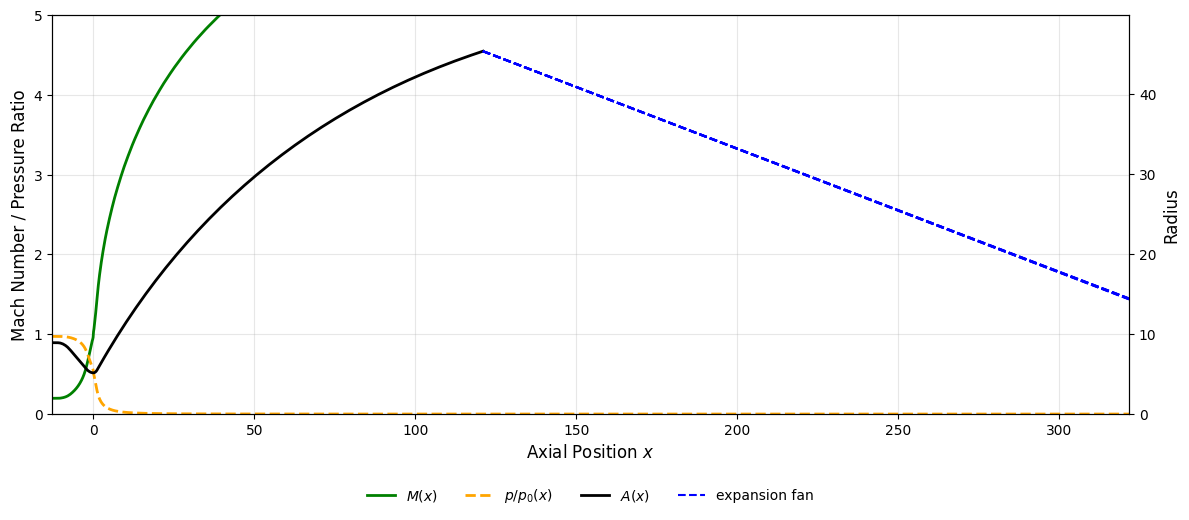

In [9]:
p_ratio = 0.00036
p_b = p_ratio*p_0
nozzle = Nozzle(A, xmin=xmin, xmax=xmax, gamma=g,R=R)
nozzle.plot_flow_profile(p_ratio)

critical pressure rato (p_b/p_0) - chock =          0.99996
critical pressure rato (p_b/p_0) - normal shock =   0.01837
critical pressure rato (p_b/p_0) - shock free =     0.00037
===
pb/p0 = 0.000 --> Sonic Throat - Expansion fan at the exit 
===


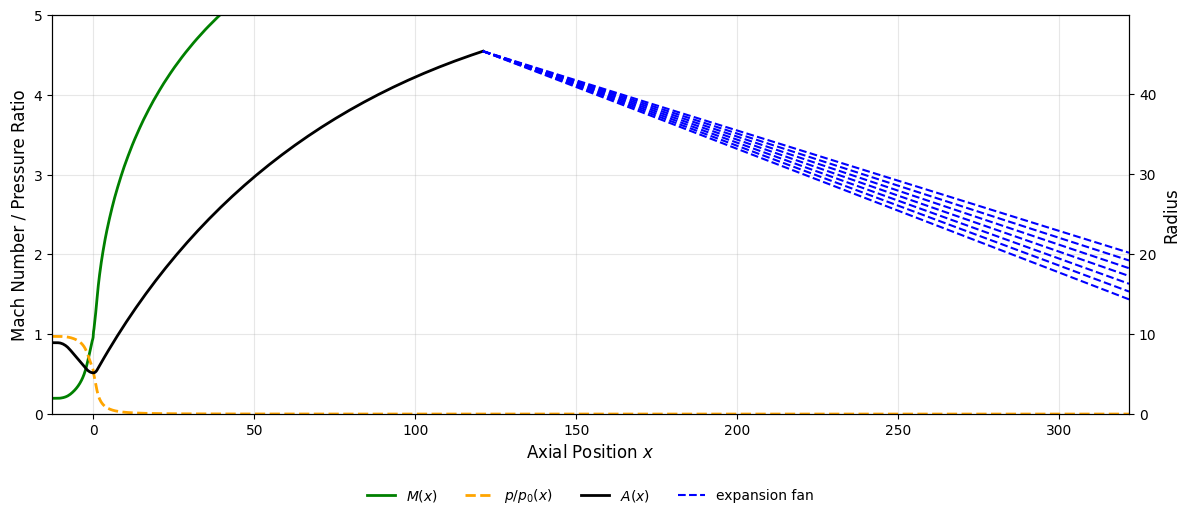

In [10]:
p_ratio = 0.0001
p_b = p_ratio*p_0
nozzle = Nozzle(A, xmin=xmin, xmax=xmax, gamma=g,R=R)
nozzle.plot_flow_profile(p_ratio)

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

nozzle = Nozzle(A, xmin=xmin, xmax=xmax, gamma=g, R=R)
from IPython.display import clear_output

# Use a real slider so you can control behavior
p_slider = widgets.FloatSlider(
    value=0.972,
    min=0.0001,
    max=1.0,
    step=0.001,
    description="p_b/p0",
    continuous_update=False,   # <-- biggest smoothness win
    readout_format=".1f",
)

def model_nozzle(p_ratio):
    # If your plotting function makes new figures, prevent buildup/flicker
    clear_output(wait=True)
    nozzle.plot_flow_profile(p_ratio)
    plt.show()

interact(model_nozzle, p_ratio=p_slider);

critical pressure rato (p_b/p_0) - chock =          0.99996
critical pressure rato (p_b/p_0) - normal shock =   0.01837
critical pressure rato (p_b/p_0) - shock free =     0.00037


interactive(children=(FloatSlider(value=0.972, continuous_update=False, description='p_b/p0', max=1.0, min=0.0…